In [4]:
from PIL import Image
import json
from glob import glob
import random
import cv2
import os
import face_alignment
import time
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from face_alignment.utils import crop
from align_trans import get_reference_facial_points, warp_and_crop_face


with open('/home/tk/datasets/MELD/MELD.Raw/train/small_dataset.json', 'r') as stream:
    small_dataset = json.load(stream)

vid_root_path = '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/'

random_dia = random.choice(small_dataset['train'])
print(f"random dialogue : {random_dia}")
print()

utts = glob(vid_root_path + random_dia + '*.mp4')
utts.sort()
print(f"number of utterance videos is {len(utts)}")
print(utts)
print()

utt = random.choice(utts)
print(f"random utt: {utt}")

cap = cv2.VideoCapture(utt)
frames = []
while True:
    success, frame = cap.read()
    if not success:
        break
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

print(f"number of frames in this utt is {len(frames)}")

random dialogue : dia180

number of utterance videos is 13
['/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt0.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt10.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt11.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt12.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt13.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt14.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt15.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt4.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt5.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt6.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt7.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt8.mp4', '/home/tk/datasets/MELD/MELD.Raw/train/train_splits/dia180_utt9.mp4']

random utt: /home/tk/da

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = ('cpu', 'cuda')[0]
face_detector = ('sfd', 'blazeface')[1]
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device=device, face_detector=face_detector)
print(device, face_detector)

batch_size = 32
num_iter = len(frames) // batch_size
landmarks = {}
faces = {}

frame_num = 0
for i in tqdm(range(num_iter)):
    batch = np.stack(frames[i*batch_size: (i+1)*batch_size])
    batch = batch.transpose(0, 3, 1, 2)
    batch = torch.Tensor(batch)
    batch = batch.to(device)

    detected_faces = fa.face_detector.detect_from_batch(batch)
    preds = fa.get_landmarks_from_batch(batch, detected_faces)

    assert len(detected_faces) == len(preds)
    for detface, pred in zip(detected_faces, preds):
        landmarks[frame_num] = pred
        faces[frame_num] = detface
        frame_num +=1

batch = np.stack(frames[num_iter*batch_size:])
batch = batch.transpose(0, 3, 1, 2)
print(batch.shape)
batch = torch.Tensor(batch)
batch = batch.to(device)

detected_faces = fa.face_detector.detect_from_batch(batch)
preds = fa.get_landmarks_from_batch(batch, detected_faces)

assert len(detected_faces) == len(preds)
for detface, pred in zip(detected_faces, preds):
    landmarks[frame_num] = pred
    faces[frame_num] = detface
    frame_num +=1


cpu blazeface



(30, 3, 720, 1280)


4


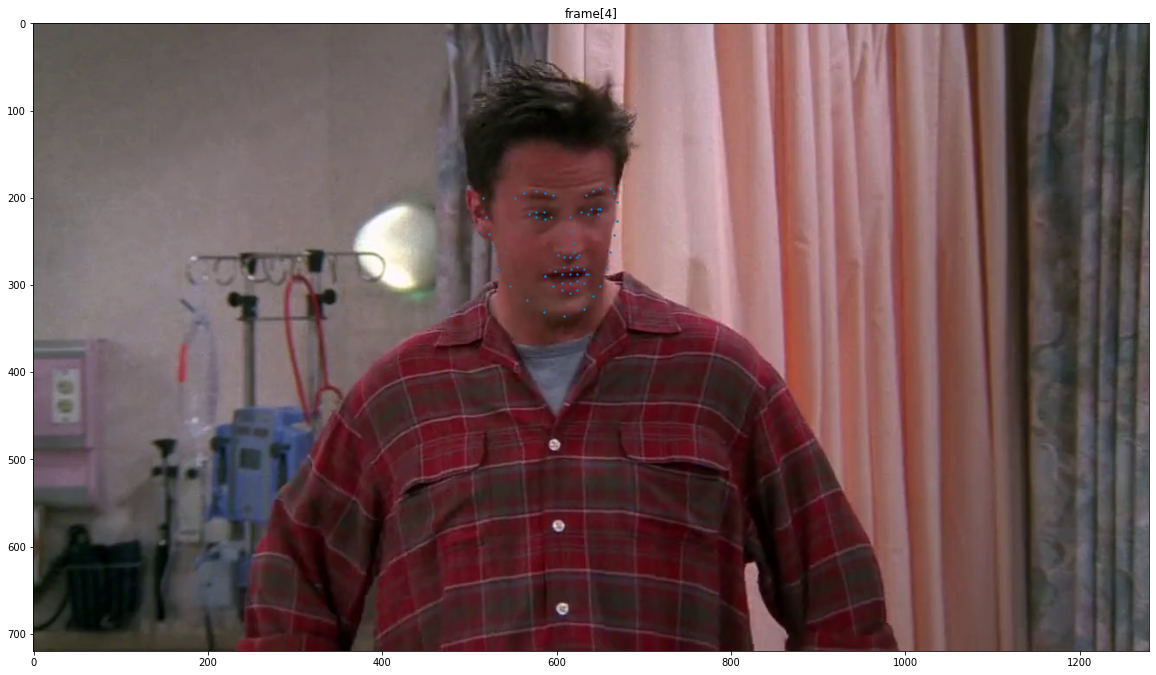

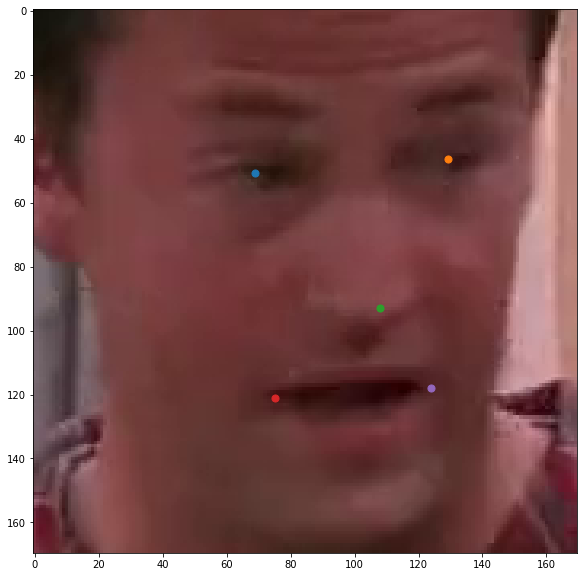

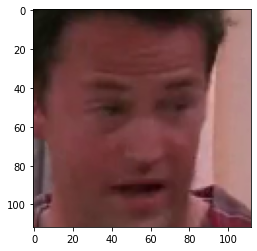

In [11]:
rand_frame_number = np.random.randint(0, len(landmarks))
print(rand_frame_number)
plt.figure(figsize=(20, 20))
plt.imshow(frames[rand_frame_number])

plt.title(f'frame[{rand_frame_number}]')
for detection in landmarks[rand_frame_number]:
    plt.scatter(detection[:,0], detection[:,1], 2)
plt.show()

cv2.imwrite('./DEBUG/foo/foo.jpg', cv2.cvtColor(frames[rand_frame_number], cv2.COLOR_BGR2RGB))

for face, landmark in zip(faces[rand_frame_number], landmarks[rand_frame_number]):
    plt.figure(figsize=(10, 10))

    x1, y1, x2, y2, prob = face.astype(int).tolist()

    cropped = frames[rand_frame_number][y1:y2, x1:x2, :]
    plt.imshow(cropped)

    landmark_shifted = landmark - np.array([x1, y1])

    eye_left_shifted = [landmark_shifted[36:42,0].mean(), landmark_shifted[36:42,1].mean()]
    eye_right_shifted = [landmark_shifted[42:48,0].mean(), landmark_shifted[42:48,1].mean()]
    nose_shifted = [landmark_shifted[30,0], landmark_shifted[30,1]]
    mouth_left_shifted = [landmark_shifted[48,0], landmark_shifted[48,1]]
    mouth_right_shifted = [landmark_shifted[54,0], landmark_shifted[54,1]]

    plt.scatter(eye_left_shifted[0], eye_left_shifted[1], 50)
    plt.scatter(eye_right_shifted[0], eye_right_shifted[1], 50)
    plt.scatter(nose_shifted[0], nose_shifted[1], 50)
    plt.scatter(mouth_left_shifted[0], mouth_left_shifted[1], 50)
    plt.scatter(mouth_right_shifted[0], mouth_right_shifted[1], 50)

    # left eyes 6points:     plt.scatter(landmark_shifted[36:42,0], landmark_shifted[36:42,1], 50)
    # right eyes 6 points:     plt.scatter(landmark_shifted[42:48,0], landmark_shifted[42:48,1], 50)
    #  nose 4 points:     plt.scatter(landmark_shifted[27:31,0], landmark_shifted[27:31,1], 50)
    # mouth:     plt.scatter(landmark_shifted[48:68,0], landmark_shifted[48:68,1], 50) 

    eye_left = [landmark[36:42,0].mean(), landmark[36:42,1].mean()]
    eye_right = [landmark[42:48,0].mean(), landmark[42:48,1].mean()]
    nose = [landmark[30,0], landmark[30,1]]
    mouth_left = [landmark[48,0], landmark[48,1]]
    mouth_right = [landmark[54,0], landmark[54,1]]

    crop_size = 112
    scale = crop_size / 112.
    reference = get_reference_facial_points(default_square = True) * scale

    facial5points = [eye_left, eye_right, nose, mouth_left, mouth_right]
    warped_face = warp_and_crop_face(np.array(frames[rand_frame_number]), facial5points, reference, crop_size=(crop_size, crop_size))

    img_warped = Image.fromarray(warped_face)
    img_warped = np.array(img_warped)
    plt.figure()
    plt.imshow(img_warped)

    plt.show()